# Multiclass Logistic Regression in PyTorch

Logistic regression is a classic algorithm for performing binary classification. It's formulation is:

$$\hat{y} = \sigma( \boldsymbol{x} \boldsymbol{w}^T + b)$$

This activation function on the final layer was crucial because it forced our outputs to take values in the range $[0,1]$. That allowed us to interpret these outputs as probabilties. We then updated our parameters to give the true labels (which take values either 1 or 0) the highest probability.

Binary classification is quite useful. We can use it to predict spam vs. not spam or cancer vs not cancer. But not every problem fits the mold of binary classification. Sometimes we encounter a problem where each example could belong to one of $k$ classes. For example, a photograph might depict a cat or a dog or a zebra or … (you get the point). Given $k$ classes, the most naive way to solve a multiclass classification problem is to train $k$ different binary classifiers. However, there’s a smarter way to go about this. We could force the output layer to be a discrete probability distribution over the $k$ classes. To be a valid probability distribution, we’ll want the output $\hat{y}$ to (i) contain only non-negative values, and (ii) sum to $1$. We accomplish this by using the **softmax** function.

Given an input vector $z$, softmax does two things. First, it exponentiates (elementwise) $e^z$, forcing all values to be strictly positive. Then it normalizes so that all values sum to $1$. Following the softmax operation computes the following

$$\text{softmax}(\boldsymbol{z}) = \frac{e^{\boldsymbol{z}} }{\sum_{i=1}^k e^{z_i}}$$

Because now we have k outputs and not 1 we’ll need weights connecting each of our inputs to each of our outputs. Graphically, the network looks something like this:

<center>![](./images/simple-softmax-net.png)</center>

We can represent these weights one for each input node, output node pair in a matrix $W$. We generate the linear mapping from inputs to outputs via a matrix-vector product $\boldsymbol{x} W + \boldsymbol{b}$. Note that the bias term is now a vector, with one component for each output node. The whole model, including the activation function can be written:

$$\hat{y} = \text{softmax}(\boldsymbol{x} W + \boldsymbol{b})$$

This model is sometimes called multiclass logistic regression. Other common names for it include softmax regression and multinomial regression.

In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare CIFAR10 dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
image_size = (32, 32, 3)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## About batch training

In the above, we used plain lowercase letters for scalar variables, bolded lowercase letters for row vectors, and uppercase letters for matrices. Assume we have $d$ inputs and $k$ outputs. Let’s note the shapes of the various variables explicitly as follows:

$$\underset{1 \times k}{\boldsymbol z} = \underset{1 \times d}{\boldsymbol{x}}\ \underset{d \times k}{W} + \underset{1 \times k}{\boldsymbol{b}}$$

Often we would one-hot encode the output label, for example $\hat{y} = 5$ would be $\boldsymbol {\hat y}_{one-hot} = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$ when one-hot encoded for a 10-class classfication problem. So $\hat{y} = \text{softmax}(\boldsymbol z)$ becomes

$$\underset{1 \times k}{\boldsymbol{\hat{y}}_{one-hot}} = \text{softmax}_{one-hot}(\underset{1 \times k}{\boldsymbol z})$$

When we input a batch of $m$ training examples, we would have matrix \underset{m \times d}{X} that is the vertical stacking of individual training examples \boldsymbol x_i, due to the choice of using row vectors.

$$\begin{split}X=
\begin{bmatrix}
    \boldsymbol x_1 \\
    \boldsymbol x_2 \\
    \vdots \\
    \boldsymbol x_m
\end{bmatrix}
=
\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1d} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{m1} & x_{m2} & x_{m3} & \dots  & x_{md}
\end{bmatrix}\end{split}$$

Under this batch training situation, $\boldsymbol{\hat{y}}_{one-hot} = \text{softmax}({\boldsymbol z})$ turns into

$$Y = \text{softmax}(Z) = \text{softmax}(XW + B)$$

where matrix $\underset{m \times k}{B}$ is formed by having $m$ copies of $\boldsymbol b$ as follows

$$\begin{split} B =
\begin{bmatrix}
    \boldsymbol b \\
    \boldsymbol b \\
    \vdots \\
    \boldsymbol b
\end{bmatrix}
=
\begin{bmatrix}
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    b_{1} & b_{2} & b_{3} & \dots  & b_{k}
\end{bmatrix}\end{split}$$

Each row of matrix $\underset{m \times k}{Z}$ corresponds to one training example. The softmax function operates on each row of matrix $Z$ and returns a matrix $\underset{m \times k}Y$, each row of which corresponds to the one-hot encoded prediction of one training example.

## Define the model with *nn.Module*

The basic modeling idea is that we’re going to linearly map our input $X$ onto 10 different real valued outputs. Then, before outputting these values, we’ll want to normalize them so that they are non-negative and sum to 1. This normalization allows us to interpret the output $\hat{y}$ as a valid probability distribution.

In [3]:
n_in = image_size[0] * image_size[1] * image_size[2]
n_o = 10

class MulticlassLogisticRegression(nn.Module):
    def __init__(self, **kwargs):
        super(MulticlassLogisticRegression, self).__init__(**kwargs)
        self.dense_1 = T.nn.Linear(n_in, n_o)
        
    def forward(self, x):
        x = x.view(-1, n_in)
        x = F.softmax(self.dense_1(x), dim=1)
        return x

In [4]:
net = MulticlassLogisticRegression()
net.to(device)

MulticlassLogisticRegression(
  (dense_1): Linear(in_features=3072, out_features=10, bias=True)
)

## Setup the loss function and optimizer

we’re going to need to define a loss function that makes sense when our prediction is a probability distribution.

The relevant loss function here is called cross-entropy and it may be the most common loss function you’ll find in all of deep learning. That’s because at the moment, classification problems tend to be far more abundant than regression problems.

The basic idea is that we’re going to take a target Y that has been formatted as a one-hot vector, meaning one value corresponding to the correct label is set to 1 and the others are set to 0, e.g. $[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]$.

The basic idea of cross-entropy loss is that we only care about how much probability the prediction assigned to the correct label. In other words, for true label 2, we only care about the component of $\hat{y}$ corresponding to 2. Cross-entropy attempts to maximize the log-likelihood given to the correct labels.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training and Evaluation

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(32):  # loop over the dataset multiple times
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 4 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 4 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')


Epoch: 0
Train Acc. => 31.816% | Train Loss => 2.16190
Test Acc.  => 36.010% | Test Loss  => 2.11805

Epoch: 4
Train Acc. => 39.890% | Train Loss => 2.07162
Test Acc.  => 39.840% | Test Loss  => 2.07304

Epoch: 8
Train Acc. => 41.632% | Train Loss => 2.05370
Test Acc.  => 40.420% | Test Loss  => 2.06144

Epoch: 12
Train Acc. => 42.618% | Train Loss => 2.04381
Test Acc.  => 40.880% | Test Loss  => 2.05595

Epoch: 16
Train Acc. => 43.272% | Train Loss => 2.03705
Test Acc.  => 41.180% | Test Loss  => 2.05183

Epoch: 20
Train Acc. => 43.896% | Train Loss => 2.03182
Test Acc.  => 41.340% | Test Loss  => 2.04989

Epoch: 24
Train Acc. => 44.184% | Train Loss => 2.02783
Test Acc.  => 41.350% | Test Loss  => 2.04837

Epoch: 28
Train Acc. => 44.658% | Train Loss => 2.02444
Test Acc.  => 41.480% | Test Loss  => 2.04627
Finished Training


## Conclusion

We can get nearly 42% accuracy at this task just by training a linear model for a few minutes! You might reasonably conclude that this problem is too easy to be taken seriously by experts.

## Visualization

In [7]:
import matplotlib.pyplot as plt

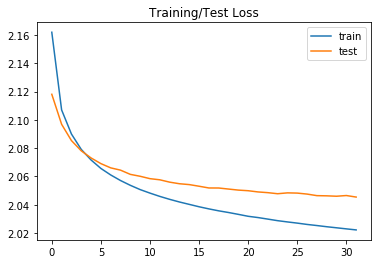

In [8]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.title('Training/Test Loss')
plt.show()

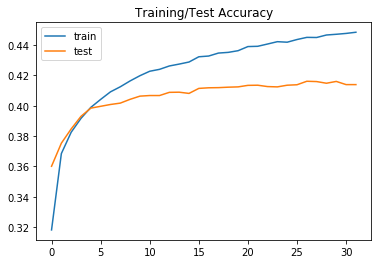

In [9]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.title('Training/Test Accuracy')
plt.show()